# **ENGG680 - Introduction to Digital Engineering**
## *Lab Assignment 3: Introduction to Machine Learning (Gradient Descent, Logistic Regression)*

## Preliminary: Certificate of Work


*We, the undersigned, certify that this is our own work, which has been done expressly for this course, either without the assistance of any other party or where appropriate we have acknowledged the work of others. Further, we have read and understood the section in the university calendar on plagiarism/cheating/other academic misconduct and we are aware of the implications thereof. We request that the total mark for this assignment be distributed as follows among group members:*

|          | First Name | Last Name | Signature (Full Name, Date) | Hours | Contribution % |
|----------|------------|-----------|-----------------------------|-------|----------------|
| Member 1: | Samarth Udayan | Pathak | Samarth Udayan Pathak, 10/22/24 | 5 | 25% |
| Member 2: | Leena Manoharlal | Panjwani | Leena Manoharlal Panjwani, 10/22/24 | 5 | 25% |
| Member 3: | Gargi Harvindersingh | Sandhu | Gargi Harvindersingh Sandhu, 10/22/24 | 5 | 25% |
| Member 4: | Dev | Joshi | Dev Joshi, 10/22/24 | 5 | 25% |


# **Non-linear Gradient Descent (25 marks)**

### **Observations:** Pseudorange [m]

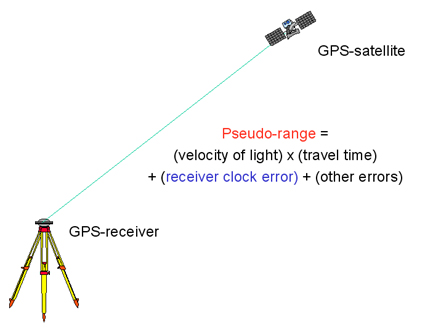

<font size="1.5">Image source: *ICA Course on Toponymy. https://unstats.un.org/unsd/geoinfo/ungegn/docs/_data_icacourses/_HtmlModules/_Selfstudy/S06/S06_05b.html.*</font>

**Pseudorange** is the *pseudo* distance between a satellite and a satellite signal receiver on the ground. In simple words, it contains the geometric range between the satellite and the receiver, with additional associated errors.

The simplified version of the Pseudorange measurement model is:
$$P=\rho-cdT+ϵ_{sum}$$ and
$$\rho=\sqrt{(x_s - x_r)^2 + (y_s - y_r)^2 + (z_s - z_r)^2}$$
where
$$\rho=geometric\ range$$
$${x_s, y_s, z_s, x_r,y_r,z_r} = 3D\ coordinates\ of\ satellite\ and\ receiver$$
$$cdT = receiver\ clock\ offset$$
$$ϵ_{sum}=general\ errors\ term\ (ϵ_{sum}=\Delta \rho + \Delta_{\text{ion}} + \Delta_{\text{trop}} + \epsilon_P + cdt)$$

\\
Note: the 3D **positions of satellites** are given in this assignment.

### **Unknown States:** Position of receiver & receiver clock offset

We use the psuedorange measurements to estimate the receiver's **3-dimensional position** and the **receiver clock offset:** $$X={x_r,y_r,z_r,cdT}$$.

These will be our states of interest, and we are going to estimate them using Gradient Descent method


.

###Step 0: Setup & Intialization

Step 0.1: Import necessary libraries

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Step 0.2: Read and parse data files

In [ ]:
df_pseudorange = pd.read_excel('/content/drive/MyDrive/engg680_2024_fall/Lab_Assignment3/pseudoranges1.xlsx')
df_sat_pos = pd.read_excel('/content/drive/MyDrive/engg680_2024_fall/Lab_Assignment3/satellite_position1.xlsx')

pseudorange = df_pseudorange['P'].to_numpy()
sat_pos =df_sat_pos[['x','y','z']].to_numpy()

n = pseudorange.size

Step 0.3: Define the groundtruth of receiver's position in ECEF (m)

In [ ]:
GroundTruth=np.array([-1633489.37967725,	-3651627.18250363,	4952481.61954918])

Step 0.4: Intialize empty arrays

In [ ]:
arr_cost= []
arr_grad= []
arr_err=[]
steps_count=0

Step 0.5: Function that
computes the euclidean distance between satellite and receiver

In [ ]:
def euclidean_norm(receiver_pos, satellite_pos):

    # Calculate the Euclidean norm (distance)
    distance = np.linalg.norm(satellite_pos - receiver_pos, axis =1)

    return distance


### Step 1: Define the Cost Function (4 marks)
Define a cost function that computes the sum of squared residuals between measured and predicted pseudoranges.

The function's inputs are: the receiver's coordinates, clock offset, satellites' coordinates, observed pseudoranges.

The function returns a single scalar.

Call euclidean_norm function to calculate geometric distance.

In [ ]:
# Cost function: sum of squared residuals between measured and predicted pseudoranges
def cost_function(r_pos, cdT, s_pos, pseudorange):
  geometric_distance = euclidean_norm(r_pos, s_pos)
  predicted_pseudorange = geometric_distance - cdT
  residuals = pseudorange - predicted_pseudorange
  L = (1/n) * np.sum(residuals ** 2)
  return L


### Step 2: Define the Gradient Computation Function (4 marks)

Define a gradient computation function that calculates the gradient of the cost function with respect to the estimates (x_r, y_r, z_r, cdT).


The function's inputs are: the receiver's coordinates, clock offset, satellites' coordinates, observed pseudoranges.


The function returns a 1D numpy array that contains 4 elements.


Call euclidean_norm function to calculate geometric distance.


In [ ]:
def gradient(r_pos, cdT, s_pos, pseudorange):

    geometric_distance = euclidean_norm(r_pos, s_pos)
    predicted_pseudorange = geometric_distance - cdT
    residuals = pseudorange - predicted_pseudorange
    grad_x_r = (-2/n) * np.sum(residuals * (r_pos[0] - s_pos[:,0]) / geometric_distance)
    grad_y_r = (-2/n) * np.sum(residuals * (r_pos[1] - s_pos[:,1]) / geometric_distance)
    grad_z_r = (-2/n) * np.sum(residuals * (r_pos[2] - s_pos[:,2]) / geometric_distance)
    grad_cdt = (-2/n) * -np.sum(residuals)
    grad = np.array([grad_x_r, grad_y_r, grad_z_r, grad_cdt])
    return grad

### Step 3: Gradient Descent Implementation (4 marks)
Construct the implementation function of gradient descent

Replace '...' with actual implementation

The function's input are: observed pseudoranges, satellites' positions, learning_rate, maximum loop iterations, tolerance

The function will return a 1D numpy array that contains the optimized estimates (x_r, y_r, z_r, cdT)

The function set learning_rate, max_iters and tolerance as: 0.01, 100000, 1e-6 as default values

These default hyperparameters values can be overridden by passing your own values when calling the function


In [ ]:
# Gradient descent algorithm for non-linear least squares estimation
def gradient_descent(pseudorange, s_pos, learning_rate=0.1, max_iters=10000, tolerance=1e-6):

    global steps_count
    print(learning_rate)

    #initalize the estimates as zeros
    X = np.array([0,0,0,0])

    for iteration in range(max_iters):
        r_pos = X[:3]
        cdT = X[3]

        # compute the cost in the current step
        # (1 mark)
        current_cost = cost_function(r_pos, cdT, s_pos, pseudorange)


        # compute the gradients in the current step
        # (1 mark)
        grad = gradient(r_pos, cdT, s_pos, pseudorange)


        # update estimates
        # (1 mark)
        X_new = X - learning_rate * grad

        # compute the new cost
        # (1 mark)
        new_cost = cost_function(X_new[:3], X_new[3], s_pos, pseudorange)

        # break the loop if converge
        if np.abs(new_cost - current_cost) < tolerance:
            print(f"Converged after {iteration} iterations.")
            steps_count=iteration
            break

        # update the parameters for the next iteration
        X = X_new

        #collect intermediate results for cost and gradients
        arr_cost.append(current_cost)
        arr_grad.append(grad)
        arr_err.append(X[:3]-GroundTruth)

    return X, arr_cost, arr_grad, arr_err

### Step 4: Parameters Optimization & Results Printing (3 marks)

Call *gradient_descent* function to optimize the estimating parameters using default optimization hyperparameters

Print:

*   optimized parameters
*   final position errors of receiver
*   number of steps taken for convergence
*   final cost value
*   final gradient values








In [ ]:
optimized_params, arr_cost, arr_grad, arr_err = gradient_descent(pseudorange, sat_pos)
final_position_errors = arr_err[-1]
final_cost = arr_cost[-1]
final_gradient = arr_grad[-1]

# print the mentioned metrics
print("Optimized Parameters:", optimized_params)
print("Final Position Errors:", final_position_errors)
print("Steps Taken:", steps_count)
print("Final Cost:", arr_cost[-1])
print("Final Gradient:", arr_grad[-1])

0.1
Converged after 2963 iterations.
Optimized Parameters: [-1.63349244e+06 -3.65162953e+06  4.95248539e+06 -6.44838347e+00]
Final Position Errors: [-3.06240566 -2.34631388  3.77147769]
Steps Taken: 2963
Final Cost: 0.5634455009259777
Final Gradient: [ 0.00015542  0.00086601 -0.00266161  0.00150894]


### Step 5: Cost vs Steps Plot & Analysis (2 marks)
Plot cost vs steps

Use 'semilogy' to scale y-axis

Label each axis

Include figure title

Comment on the pattern from the plot

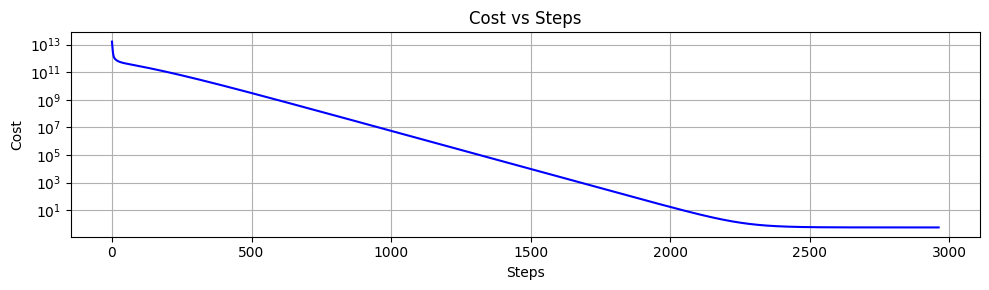

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 3))
ax.semilogy(arr_cost, linestyle= '-', color='b')
ax.set_xlabel("Steps")
ax.set_ylabel("Cost")
ax.set_title("Cost vs Steps")
ax.grid(True)
fig.tight_layout()
plt.show()


# Comment on the pattern
# The pattern shows an efficient convergence of the gradient descent algorithm, with an initial steep decrease in cost followed by gradual convergence to a stable minimum.


### Step 6: Gradients vs Steps & Analysis(2 marks)
Plot gradients vs steps

use 'symlog' to scale y-axis

use 'tick_params' and set y-axis: labelsize=8

include axes' labels, legends and title

Comment on the pattern from the plot

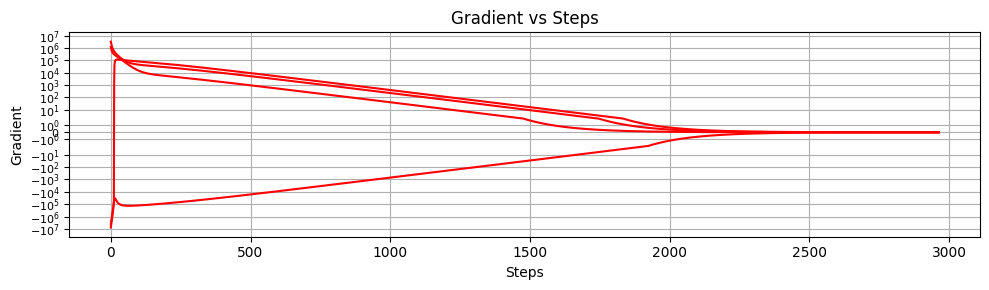

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 3))
ax.plot(arr_grad, linestyle= '-', color='red')
ax.set_yscale('symlog')
ax.tick_params(axis='y', labelsize=8)
ax.set_xlabel("Steps")
ax.set_ylabel("Gradient")
ax.set_title("Gradient vs Steps")
ax.grid(True)
fig.tight_layout()
plt.show()


# Comment on the pattern
# The pattern in this plot indicates a successful gradient descent process, where the gradient decreases quickly at the beginning and then gradually approaches zero, signaling convergence.

### Step 7: Positioning errors vs Steps & Analysis(2 marks)
Plot positioning errors vs steps

Include axes' labels, legends and title

Comment on the pattern of the plot

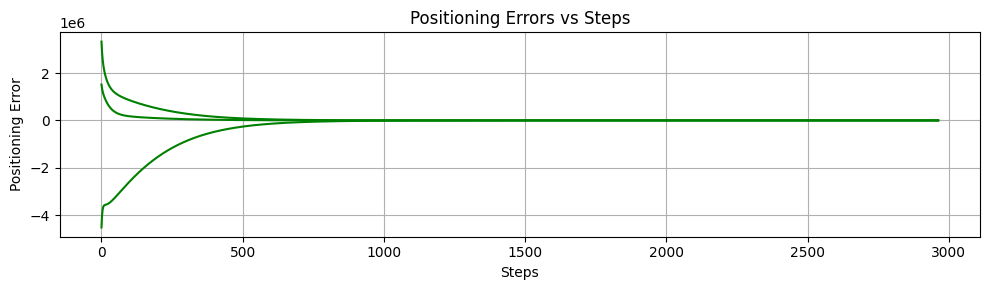

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 3))
ax.plot(arr_err, linestyle='-', color='green')
ax.set_xlabel("Steps")
ax.set_ylabel("Positioning Error")
ax.set_title("Positioning Errors vs Steps")
ax.grid(True)
fig.tight_layout()
plt.show()


# Comment on the pattern
# The pattern shows a successful optimization process where the algorithm quickly reduces the positioning error from a high initial value, oscillates as it fine-tunes the position, and finally converges to a stable, low error.

# Hyperparameters Tuning

*   List item
*   List item



### Step 8: Tuning Learning rate (2 marks)

Change learning rate to 0.01, 0.001 and repeat step 4.

(*hint: you may need to adjust the maximum loop iterations in this case*)

In [ ]:
#set learning rate to 0.01
#re-initialize arrays and counters
arr_cost = []
arr_grad = []
arr_err = []
steps_count = 0

optimized_params_2, arr_cost, arr_grad, arr_err = gradient_descent(pseudorange, sat_pos,0.01)

# print the metrics
print("Optimized Parameters:", optimized_params_2)

0.01
Optimized Parameters: [-1632831.67478494 -3647949.08713054  4941174.43755047     6408.12065437]


In [ ]:
#set learning rate to 0.001
#re-initialize arrays and counters
arr_cost = []
arr_grad = []
arr_err = []
steps_count = 0

optimized_params_3, arr_cost, arr_grad, arr_err = gradient_descent(pseudorange, sat_pos,0.001)

# print the metrics
print("Optimized Parameters:", optimized_params_3)

0.001
Optimized Parameters: [-1456131.06049278 -2794627.49109828  2359993.40248177  1573224.39421376]


## Step 9: Results Analysis (2 marks)

Q1. Comment on the difference that you notice after changing the learning rate. (1 mark)

Q2. What is the difference between LSE and Gradient Descent? (Comment based on your results and the methodology) (1 mark)



ANSWER HERE

ANSWER-1

A lower learning rate (0.001) provides more stability but may require more steps, while a higher learning rate (0.01) can lead to faster but potentially unstable convergence, resulting in large, possibly unrealistic parameter values.

ANSWER-2

LSE provides a more direct solution for linear problems, while Gradient Descent requires careful tuning and iterative adjustments to achieve convergence, especially in non-linear contexts.

---
---

# **Logistic Regression (50 marks)**

The following dataset helps to predict phishing webpages. It is collected mainly from: PhishTank archive, MillerSmiles archive, Googleâ€™s searching operators.

It can be downloaded from : https://archive.ics.uci.edu/dataset/327/phishing+websites

<u>Class labels:</u>

Not phishing = -1

Phishing = 1



Follow the steps provided to perform binary classification using logistic regression and complete the code for each part.


### Step 0: Import Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

### Step 1: Data Input (2 mark)

Use the `fetch_ucirepo(id=<ID>)`  to load the phishing dataset (id = 327) as a dataframe into the feature matrix `X` and target vector `y`.

Print the size of `X` and `y`


In [3]:
!pip install ucimlrepo

In [4]:
from ucimlrepo import fetch_ucirepo

phishing_websites = fetch_ucirepo(id=327)

X = phishing_websites.data.features
y = phishing_websites.data.targets

print("Size of X:", X.shape)
print("Size of y:", y.shape)


Size of X: (11055, 30)
Size of y: (11055, 1)


### Step 2.1: Class label histogram (2 marks)

Plot the histogram for each class label to visualise class imbalance. Additionally before calling .show() for the plot, ensure that the code displays you the exact value of the samples for each class above the respective bins.

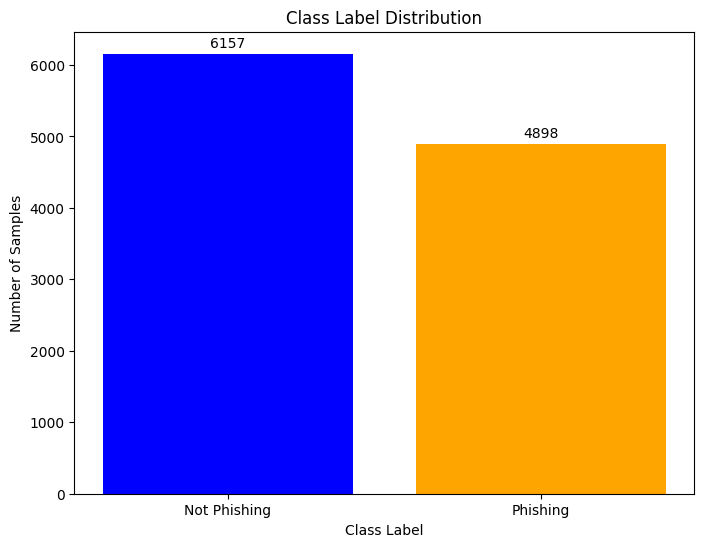

In [5]:
class_counts = y.value_counts()

plt.figure(figsize=(8, 6))
bars = plt.bar(class_counts.index.map(str), class_counts.values, color=['blue', 'orange'])
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 50, int(yval), ha='center', va='bottom')

plt.xlabel('Class Label')
plt.ylabel('Number of Samples')
plt.title('Class Label Distribution')
plt.xticks(class_counts.index.map(str), ['Not Phishing', 'Phishing'])
plt.show()

### Step 2.2: Smaller dataset creation(2 mark)


We also want to test if the model would still work if we used less data. Use the `train_test_split` function from sklearn to create a new feature matrix named `X_small` and a new target vector named `y_small` that contain **3%** of the data.

Use random_state = 42


In [6]:
pip install scikit-learn

In [25]:
from ucimlrepo import fetch_ucirepo
from sklearn.model_selection import train_test_split

phishing_websites = fetch_ucirepo(id=327)

X = phishing_websites.data.features
y = phishing_websites.data.targets
X_small, _, y_small, _ = train_test_split(X, y, test_size=0.97, random_state=42)

# Display sizes of X_small and y_small
print("Size of X_small:", X_small.shape)
print("Size of y_small:", y_small.shape)

Size of X_small: (331, 30)
Size of y_small: (331, 1)


### Step 3: Implement Machine Learning Model (6 marks)

1. Import `LogisticRegression` from sklearn
2. Instantiate model `LogisticRegression(max_iter=2000)`
3. Implement the machine learning model with three different datasets:
    - `X` and `y` (1 mark)
    - Only first two columns of `X` and `y` (1 mark)
    - `X_small` and `y_small` (1 mark)

In [8]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split
from ucimlrepo import fetch_ucirepo
import pandas as pd

# Fetch the phishing dataset
phishing_websites = fetch_ucirepo(id=327)

# Convert the data to pandas dataframes
X = pd.DataFrame(phishing_websites.data.features, columns=phishing_websites.data.feature_names)
# The targets attribute is likely a DataFrame. Convert it to a Series and then flatten:
y = pd.Series(phishing_websites.data.targets.values.ravel(), name='Result')

# Create a smaller dataset with 3% of the data
X_small, _, y_small, _ = train_test_split(X, y, test_size=0.97, random_state=42)

# Step 3: Implement Machine Learning Model

# Instantiate the model
model = LogisticRegression(max_iter=2000)

# 1. Implement the model with X and y
model.fit(X, y)
y_pred = model.predict(X)
print("Accuracy with X and y:", accuracy_score(y, y_pred))
print("Classification Report with X and y:\n", classification_report(y, y_pred))

# 2. Implement the model with only first two columns of X and y
X_first_two_columns = X.iloc[:, :2]
model.fit(X_first_two_columns, y)
y_pred_first_two = model.predict(X_first_two_columns)
print("Accuracy with first two columns of X and y:", accuracy_score(y, y_pred_first_two))
print("Classification Report with first two columns of X and y:\n", classification_report(y, y_pred_first_two))

# 3. Implement the model with X_small and y_small
model.fit(X_small, y_small)
y_pred_small = model.predict(X_small)
print("Accuracy with X_small and y_small:", accuracy_score(y_small, y_pred_small))
print("Classification Report with X_small and y_small:\n", classification_report(y_small, y_pred_small))

Accuracy with X and y: 0.9281772953414744
Classification Report with X and y:
               precision    recall  f1-score   support

          -1       0.93      0.91      0.92      4898
           1       0.93      0.95      0.94      6157

    accuracy                           0.93     11055
   macro avg       0.93      0.93      0.93     11055
weighted avg       0.93      0.93      0.93     11055

Accuracy with first two columns of X and y: 0.5610131162369968
Classification Report with first two columns of X and y:
               precision    recall  f1-score   support

          -1       0.51      0.31      0.38      4898
           1       0.58      0.76      0.66      6157

    accuracy                           0.56     11055
   macro avg       0.54      0.54      0.52     11055
weighted avg       0.55      0.56      0.54     11055

Accuracy with X_small and y_small: 0.945619335347432
Classification Report with X_small and y_small:
               precision    recall  f1-score 

### Step 4: Test Model (6 x 3 = 18 marks)

Calculate the following for the **three different tests** implemented in Step 3
1. data size (1 mark)
1. number of training samples (1 mark)
2. number of testing samples (1 mark)
4. training accuracy (1 marks)
5. testing accuracy (1 marks)
6. log loss (1 mark)

In [9]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, log_loss
from sklearn.model_selection import train_test_split
from ucimlrepo import fetch_ucirepo
import pandas as pd

# Fetch the phishing dataset
phishing_websites = fetch_ucirepo(id=327)

# Convert the data to pandas dataframes
X = pd.DataFrame(phishing_websites.data.features, columns=phishing_websites.data.feature_names)
# Instead of flatten, use values.ravel() to get a 1D array from the DataFrame
y = pd.Series(phishing_websites.data.targets.values.ravel(), name='Result')

# Create a smaller dataset with 3% of the data
X_small, _, y_small, _ = train_test_split(X, y, test_size=0.97, random_state=42)

# Function to calculate and print the required metrics
def evaluate_model(model, X_train, y_train, X_test, y_test):
    # Calculate training accuracy
    y_train_pred = model.predict(X_train)
    train_accuracy = accuracy_score(y_train, y_train_pred)

    # Calculate testing accuracy
    y_test_pred = model.predict(X_test)
    test_accuracy = accuracy_score(y_test, y_test_pred)

    # Calculate log loss
    y_test_prob = model.predict_proba(X_test)
    test_log_loss = log_loss(y_test, y_test_prob)

    # Print the results
    print("Data size:", X_train.shape[0] + X_test.shape[0])
    print("Number of training samples:", X_train.shape[0])
    print("Number of testing samples:", X_test.shape[0])
    print("Training accuracy:", train_accuracy)
    print("Testing accuracy:", test_accuracy)
    print("Log loss:", test_log_loss)

# Split the data into training and testing sets for evaluation
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
X_first_two_columns = X.iloc[:, :2]
X_first_two_columns_train, X_first_two_columns_test, y_first_two_columns_train, y_first_two_columns_test = train_test_split(X_first_two_columns, y, test_size=0.3, random_state=42)
X_small_train, X_small_test, y_small_train, y_small_test = train_test_split(X_small, y_small, test_size=0.3, random_state=42)

# Instantiate the model
model = LogisticRegression(max_iter=2000)

# Evaluate the model with the full dataset (X and y)
print("Evaluation with X and y:")
model.fit(X_train, y_train)
evaluate_model(model, X_train, y_train, X_test, y_test)

# Evaluate the model with only the first two columns of X and y
print("\nEvaluation with first two columns of X and y:")
model.fit(X_first_two_columns_train, y_first_two_columns_train)
evaluate_model(model, X_first_two_columns_train, y_first_two_columns_train, X_first_two_columns_test, y_first_two_columns_test)

# Evaluate the model with the smaller dataset (X_small and y_small)
print("\nEvaluation with X_small and y_small:")
model.fit(X_small_train, y_small_train)
evaluate_model(model, X_small_train, y_small_train, X_small_test, y_small_test)

Evaluation with X and y:
Data size: 11055
Number of training samples: 7738
Number of testing samples: 3317
Training accuracy: 0.9311191522357198
Testing accuracy: 0.9219173952366596
Log loss: 0.1879422332411945

Evaluation with first two columns of X and y:
Data size: 11055
Number of training samples: 7738
Number of testing samples: 3317
Training accuracy: 0.5540191263892479
Testing accuracy: 0.5773289116671692
Log loss: 0.6773543714260858

Evaluation with X_small and y_small:
Data size: 331
Number of training samples: 231
Number of testing samples: 100
Training accuracy: 0.948051948051948
Testing accuracy: 0.93
Log loss: 0.19231080415833343


### Step 5.1: Visualize Results (3 marks)

1. Create a pandas DataFrame `results` with columns: Data size, training samples, testing samples, training accuracy, testing accuracy, log loss
2. Add these columns for each dataset to the `results` DataFrame
3. Print `results`

For any **random state** parameters from this step onwards, you can use random_state = 0;

In [10]:
#TO DO: Complete steps 3,4, and 5.1 in this code block (Total 27 marks)

# Note: 70% training set, 30% testing set
# HINT: create a function that calculates all required information

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, log_loss
from sklearn.model_selection import train_test_split
import pandas as pd

# Assuming X and y are already defined as the feature matrix and target vector

# Create a smaller dataset with 3% of the data
X_small, _, y_small, _ = train_test_split(X, y, test_size=0.97, random_state=0)

# Function to calculate and return the required metrics
def evaluate_model(model, X_train, y_train, X_test, y_test):
    # Calculate training accuracy
    y_train_pred = model.predict(X_train)
    train_accuracy = accuracy_score(y_train, y_train_pred)

    # Calculate testing accuracy
    y_test_pred = model.predict(X_test)
    test_accuracy = accuracy_score(y_test, y_test_pred)

    # Calculate log loss
    y_test_prob = model.predict_proba(X_test)
    test_log_loss = log_loss(y_test, y_test_prob)

    # Return the results as a dictionary
    return {
        "Data size": X_train.shape[0] + X_test.shape[0],
        "Training samples": X_train.shape[0],
        "Testing samples": X_test.shape[0],
        "Training accuracy": train_accuracy,
        "Testing accuracy": test_accuracy,
        "Log loss": test_log_loss
    }

# Split the data into training and testing sets for evaluation
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
X_first_two_columns = X.iloc[:, :2]
X_first_two_columns_train, X_first_two_columns_test, y_first_two_columns_train, y_first_two_columns_test = train_test_split(X_first_two_columns, y, test_size=0.3, random_state=0)
X_small_train, X_small_test, y_small_train, y_small_test = train_test_split(X_small, y_small, test_size=0.3, random_state=0)

# Instantiate the model
model = LogisticRegression(max_iter=2000)

# Evaluate the model with the full dataset (X and y)
model.fit(X_train, y_train)
results_full = evaluate_model(model, X_train, y_train, X_test, y_test)

# Evaluate the model with only the first two columns of X and y
model.fit(X_first_two_columns_train, y_first_two_columns_train)
results_first_two_columns = evaluate_model(model, X_first_two_columns_train, y_first_two_columns_train, X_first_two_columns_test, y_first_two_columns_test)

# Evaluate the model with the smaller dataset (X_small and y_small)
model.fit(X_small_train, y_small_train)
results_small = evaluate_model(model, X_small_train, y_small_train, X_small_test, y_small_test)

# Create a pandas DataFrame to store the results
results_df = pd.DataFrame([results_full, results_first_two_columns, results_small],
                          index=["Full Dataset", "First Two Columns", "Smaller Dataset"])

# Print the results DataFrame
print(results_df)




                   Data size  Training samples  Testing samples  \
Full Dataset           11055              7738             3317   
First Two Columns      11055              7738             3317   
Smaller Dataset          331               231              100   

                   Training accuracy  Testing accuracy  Log loss  
Full Dataset                0.932282          0.922822  0.190326  
First Two Columns           0.562807          0.556828  0.683573  
Smaller Dataset             0.956710          0.920000  0.243140  


### Step 5.2: Visualize Classification Errors (6 marks)

In this section, print the confusion matrix and the classification report to investigate the number of false positives vs. false negatives. Use the full dataset for this analysis

In [11]:
# TO DO: Retrieve target vector and predicted values for testing set using full dataset and print the dimension of the predicted output (2 mark)
# Note: 70% training set, 30% testing set
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, log_loss, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
import pandas as pd

# Assuming X and y are already defined as the feature matrix and target vector

# Split the data into training and testing sets for evaluation
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

# Instantiate the model
model = LogisticRegression(max_iter=2000)

# Train the model with the full dataset (X and y)
model.fit(X_train, y_train)

# Retrieve target vector and predicted values for testing set using full dataset
y_pred = model.predict(X_test)

# Print the dimension of the predicted output
print("Dimension of the predicted output:", y_pred.shape)

# Print the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:\n", conf_matrix)

# Print the classification report
class_report = classification_report(y_test, y_pred)
print("Classification Report:\n", class_report)



Dimension of the predicted output: (3317,)
Confusion Matrix:
 [[1341  157]
 [  99 1720]]
Classification Report:
               precision    recall  f1-score   support

          -1       0.93      0.90      0.91      1498
           1       0.92      0.95      0.93      1819

    accuracy                           0.92      3317
   macro avg       0.92      0.92      0.92      3317
weighted avg       0.92      0.92      0.92      3317



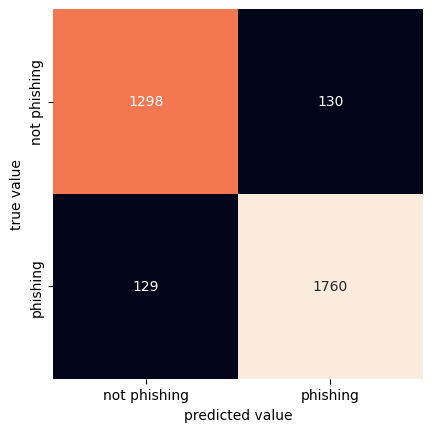

In [14]:
import seaborn as sns

# TO DO: Calculate confusion matrix (2 marks) : conf_mat
conf_mat = confusion_matrix(y_test, y_pred)
# Below code prints confusion matrix using a heatmap
sns.heatmap(conf_mat, xticklabels=['not phishing', 'phishing'],  yticklabels=['not phishing', 'phishing'], square=True, annot=True, cbar=False, fmt='d')
plt.xlabel('predicted value')
plt.ylabel('true value')
plt.show()

In [17]:
# TO DO: Print classification report (2 marks)
from sklearn.metrics import classification_report

# Print the classification report (2 marks)
class_report = classification_report(y_test, y_pred, target_names=['not phishing', 'phishing'])
print("Classification Report:")
print(class_report)

Classification Report:
              precision    recall  f1-score   support

not phishing       0.91      0.91      0.91      1428
    phishing       0.93      0.93      0.93      1889

    accuracy                           0.92      3317
   macro avg       0.92      0.92      0.92      3317
weighted avg       0.92      0.92      0.92      3317



### Questions (11 marks)
1. Is the dataset imbalanced? Does it affect model performance? (1 mark)
2. Does the model overfit or underfit for each of the 3 cases? (3 marks)
3. How do the training and testing accuracy change depending on the amount of data used? Explain with values. (1 mark)
4. In this case, what do a false positive and a false negative represent? Which one is worse? (2 marks)
5. Based on your answer to question 4, would you want to maximize precision or recall? How would you do this? (2 marks)
6. Based on the Log Loss for each of the 3 cases, what can you say about the model in each instance? What is potentially causing these differences? (2 mark)


ANSWER HERE

---
---
1.To determine if the dataset is imbalanced, you need to check the distribution of the classes. If one class significantly outnumbers the other, the dataset is considered imbalanced. This can affect model performance by making it biased towards the majority class, potentially leading to poor performance on the minority class. For example, in a binary classification problem with 90% of instances belonging to class A and 10% to class B, the model might simply predict class A most of the time to achieve high accuracy, but it would perform poorly on class B.


2.Overfitting occurs when the model performs well on the training data but poorly on the testing data, indicating that it has learned the training data too well, including noise and outliers. Underfitting happens when the model performs poorly on both training and testing data, indicating that it hasn’t learned the underlying patterns in the data.

To determine if your model is overfitting or underfitting, you can compare the training and testing accuracies or losses for each case:

Case 1: If training accuracy is high but testing accuracy is low, the model is likely overfitting.

Case 2: If both training and testing accuracies are low, the model is likely underfitting.

Case 3: If both training and testing accuracies are high and close to each other, the model is likely well-fitted.

3.Generally, as the amount of training data increases, both training and testing accuracy should improve. This is because more data provides the model with more information to learn from, reducing the likelihood of overfitting and underfitting. For example:

With 1000 samples, you might see training accuracy of 90% and testing accuracy of 85%.
With 5000 samples, these might increase to 95% and 90%, respectively.


4.False Positive: When a genuine occurrence is mistakenly labeled as phishing, this is known as a false positive.

False Negative: When a phishing instance is mistakenly categorized as authentic, it is known as a false negative.

Worse: Since a false negative does not shield consumers from real phishing threats, it is often worst in phishing detection. False negatives can result in significant security flaws, whereas false positives are inconvenient.

5.Recall should be increased in order to reduce false negatives. Recall quantifies the fraction of genuine phishing incidents that are accurately recognized. Higher recollection means fewer phishing attempts get unnoticed.

To improve recall, we may reduce the threshold for identifying an event as phishing. This means that more incidents will be defined as phishing, lowering the likelihood of false negatives while perhaps raising false positives.

6.Log Loss is a measure of how closely the model's projected probability correspond to the actual classes. Lower Log Loss shows that the anticipated probabilities are closer to the actual labels.

Complete Dataset: The Log Loss is most likely to be the lowest for the complete dataset since the model has access to all characteristics and sufficient data to produce more accurate predictions.

First two columns of X: Using only the first two attributes restricts the model's information, which will likely result in a greater Log Loss. The model may struggle to discriminate between phishing and genuine cases adequately.

Smaller Dataset (X_small and y_small): With only 3% of the data, the model may overfit or underfit depending on how the data is distributed in the small sample. This constraint is likely to result in a larger Log Loss since the model has fewer data to learn the patterns efficiently.

Causes of Differences:
Feature Limitation: Restricting the model to only two characteristics decreases its capacity to properly differentiate classes, resulting in lower performance.
Data Limitation: Using a smaller dataset limits the model's training, resulting in probable underfitting or overfitting, and hence increased Log Loss.


